# Residence and Networking

Solute setup is covered in detail in the `basics_tutorial` so it will not be covered here.

If you are new to `solvation_analysis` check there first!

In [1]:
# imports
import MDAnalysis as mda
from solvation_analysis.solute import Solute

# define paths to data
data = "../../solvation_analysis/tests/data/bn_fec_data/bn_fec.data"
traj = "../../solvation_analysis/tests/data/bn_fec_data/bn_fec_short_unwrap.dcd"

# instantiate Universe
u = mda.Universe(data, traj)

# define solute AtomGroup
li_atoms = u.atoms.select_atoms("type 22")

# define solvent AtomGroups
PF6 = u.atoms.select_atoms("byres type 21")
BN = u.atoms.select_atoms("byres type 5")
FEC = u.atoms.select_atoms("byres type 19")

solute = Solute.from_atoms(li_atoms, {'PF6': PF6, 'BN': BN, 'FEC': FEC}, radii={'PF6': 2.6})

solute.run()

We will be covering the `Residence` and `Networking` analysis objects. Though these are easy to instantiate and use, they are not instantiated by default because they can be expensive.

We'll start with `Residence`, which we will instantiate with the `from_solute` method.

## Calculating Residence Times

In [2]:
from solvation_analysis.residence import Residence

# warnings are expected
residence = Residence.from_solute(solute)

/Users/orioncohen/miniconda3/envs/solvation_analysis/lib/python3.8/site-packages/pandas/core/apply.py:131: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  return func(x, *args, **kwargs)
/Users/orioncohen/projects/development/solvation-analysis/solvation-analysis/solvation_analysis/residence.py:148: UserWarning: the autocovariance for BN does not converge to zero so a residence time cannot be calculated. A longer simulation is required to get a valid estimate of the residence time.
  warnings.warn(f'the autocovariance for {res_name} does not converge to zero '
/Users/orioncohen/projects/development/solvation-analysis/solvation-analysis/solvation_analysis/residence.py:148: UserWarning: the autocovariance for FEC does not converge to zero so a residence time cannot be calculated. A longer simulation is required to get a valid estimate of the residence time.
  warnings.warn(f'the autocovariance for {res_name} does not converge to zero '
/Users/orioncohen/pro

Because we are only looking at a very short snapshot of the simulation, the residence times here are NOT physically meaningful. That's why we get so many warnings. For the sake of the tutorial, let's imagine that we had a long enough simulation to get good results.

Residence automatically calculates the residence times of all the solvents with either with either a "cutoff" method or a "fit" method. The documentation of Residence has more detail, but in brief, fit is more accurate and cutoff is less prone to convergence issues.

In [3]:
# these will strongly disagree because our simulation time is too short
print("The cutoff residence times are: ", residence.residence_times_cutoff)
print("The fit residence times are:    ", residence.residence_times_fit)

The cutoff residence times are:  {'BN': nan, 'FEC': 6, 'PF6': 9}
The fit residence times are:     {'BN': 4.63, 'FEC': 2.88, 'PF6': 1.15}


We have two methods for binding the `Residence` object to our `Solute` object. We can "monkey patch" our residence object directly into `Solute`.

In [4]:
solute.residence = residence
solute.residence

Or we can instantiate our Solute with the Residence object included, shown below.

This dichotomy of monkey-patching with `from_solution` vs specifying in the `analysis_classes` keyword applies to all the analysis classes in `solvation-analyis`.

In [5]:
solute = Solute.from_atoms(
    li_atoms,
    {'PF6': PF6, 'BN': BN, 'FEC': FEC},
    radii={'PF6': 2.6},
    analysis_classes=["pairing", "coordination", "speciation", "residence"],
)
solute.run()

Networking follows an identical setup pattern except we specify which solvents should participate in the network. For example, in the example below we are interested in the network of cations and anions in a battery electrolyte. It doesn't make sense to include the solvents in the network, so we choose to only look at networking with the anion.

## Parsing Network Structure

In [6]:
from solvation_analysis.networking import Networking

networking = Networking.from_solute(solute, 'PF6')

Now that we have the network, lets examine the core data structure of the `Networking` object.

In [7]:
networking.network_df

solvent solvent_ix
frame network                     
0     0             PF6        603
      0        solute_0        683
      0        solute_0        690
      1             PF6        616
      1        solute_0        670
...                 ...        ...
9     1        solute_0        693
      2             PF6        623
      2        solute_0        664
      3             PF6        648
      3        solute_0        668

[112 rows x 2 columns]

The `network_df` includes all of the solutes coordinated with at least one solvent, if these coordinated solvents form a network, they are grouped together into a single item in the `network` column of the dataframe.

Here, we can see that in frame 0, our 0th network has two solutes and one PF6 solvent and our 1st network has one solute and one solvent.

The second column lists the residue indexes (from the MDAnalysis Universe) of each listed species.

`Networking` also calculates several convenient statistics, such as the clusters size distribution:

In [8]:
networking.network_sizes

solvent,2,3
frame,,
0,4,2
1,4,1
2,5,1
3,6,0
4,6,0
5,3,0
6,5,0
7,7,0
8,4,1


and the "solute status", or whether the solute is uncoordinated, coordinated with a single solvent, or in a network.

In [9]:
networking.solute_status

{'isolated': 0.8918367346938776,
 'paired': 0.09591836734693877,
 'networked': 0.012244897959183671}

As before, we can instantiate a `Networking` object in the solution directly, but this time, we'll need to specify the solvent(s) of interest in the `networking_solvents` kwarg.

In [10]:
solute = Solute.from_atoms(
    li_atoms,
    {'PF6': PF6, 'BN': BN, 'FEC': FEC},
    radii={'PF6': 2.6},
    analysis_classes=["pairing", "coordination", "speciation", "networking"],
    networking_solvents='PF6'
)
solute.run()

## Visualizing Networks

Finally, we can effectively integrate the networking object into a visualization workflow by using the residue indexes and to select the cluster's AtomGroup. This example relies on understanding the content in the Visualization Tutorial.

For this, we'll need to quickly spin up a different solution to use as an example.

In [11]:
from solvation_analysis.tests import datafiles

# instantiate Universe
u = mda.Universe(datafiles.ea_fec_pdb, datafiles.ea_fec_dcd)

# define solute AtomGroup
li_atoms = u.atoms.select_atoms("element Li")

# define solvent AtomGroups
EA = u.residues[0:235].atoms                    # ethyl acetate
FEC = u.residues[235:600].atoms                 # fluorinated ethylene carbonate
PF6 = u.atoms.select_atoms("byres element P")   # hexafluorophosphate

# instantiate solute
solute2 = Solute.from_atoms(
    li_atoms,
    {'EA': EA, 'FEC': FEC, 'PF6': PF6},
    radii={'PF6': 2.6, 'FEC': 2.7},
    solute_name="Li",
    analysis_classes=["pairing", "coordination", "speciation", "networking"],
    networking_solvents=['PF6', 'FEC']
)

solute2.run()

For the sake of getting a nice big cluster to visualize, we use both PF6 and FEC as networking solvents, this isn't particularly interesting scientifically, but it's nicer to look at!

In [12]:
networking = solute2.networking
networking.network_df.head(32)

solvent solvent_ix
frame network                   
0     0           FEC        236
      0           FEC        245
      0            Li        653
      1           FEC        238
      1            Li        603
      2           FEC        239
      2           FEC        241
      2           FEC        533
      2            Li        660
      3           FEC        242
      3            Li        639
      4           FEC        243
      4           FEC        494
      4            Li        635
      5           FEC        244
      5           FEC        413
      5           FEC        580
      5            Li        609
      6           FEC        247
      6           FEC        264
      6           FEC        274
      6           FEC        381
      6           FEC        523
      6           FEC        540
      6           FEC        541
      6           FEC        573
      6            Li        612
      6            Li        631
      6            Li        658
      7           FEC        248
      7           FEC        306
      7           FEC        460

In [13]:
# import nglview
import nglview as nv
from IPython.display import Image

def visualize(atom_group):
    mda_view = nv.show_mdanalysis(atom_group)
    return mda_view.display()

res_ix = networking.get_network_res_ix(6, 0)
network = solute2.u.residues[res_ix.astype(int)].atoms

visualize(network)

NGLWidget(max_frame=9)

The network wraps around the periodic boundary so we can't quite visualize it in one frame, but this is most of it:

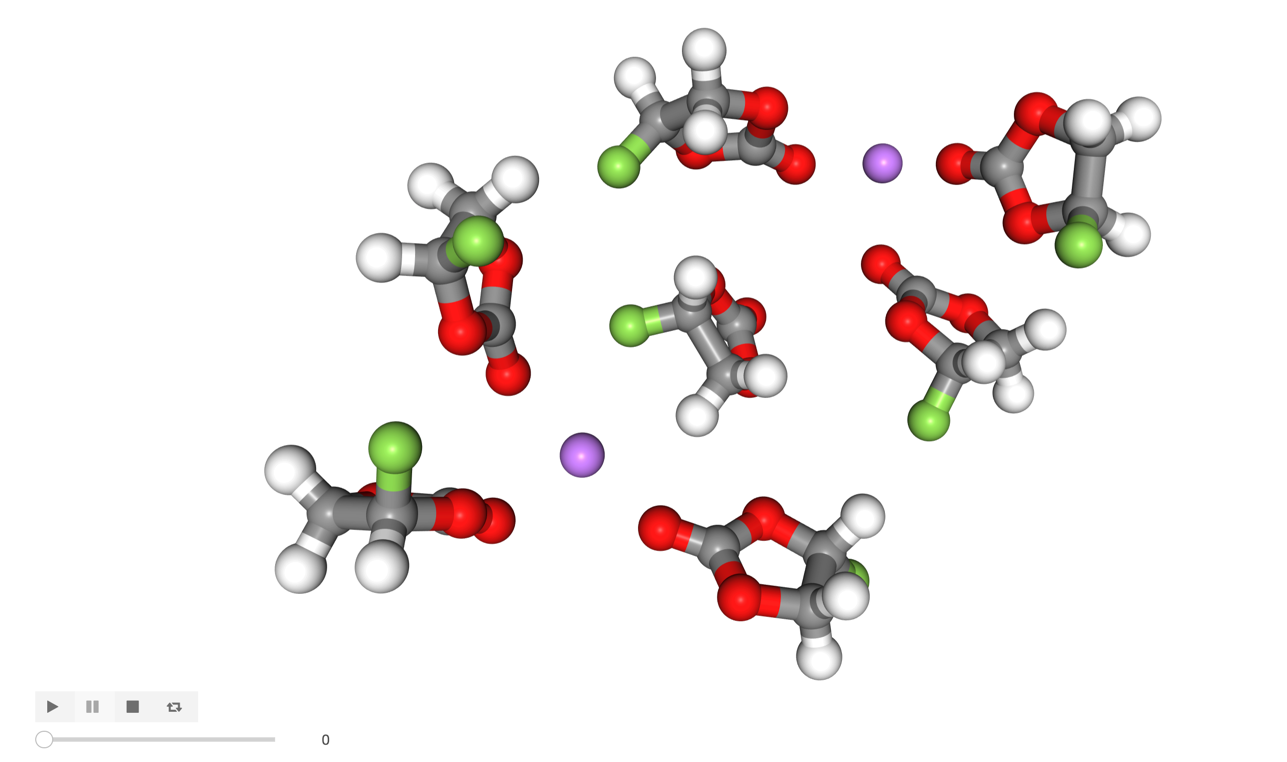

In [14]:
Image('images/network.png', width=600)

Great! Now you should understand how to use both the `Residence` and `Networking` tools, for more detail, check out the documentation.